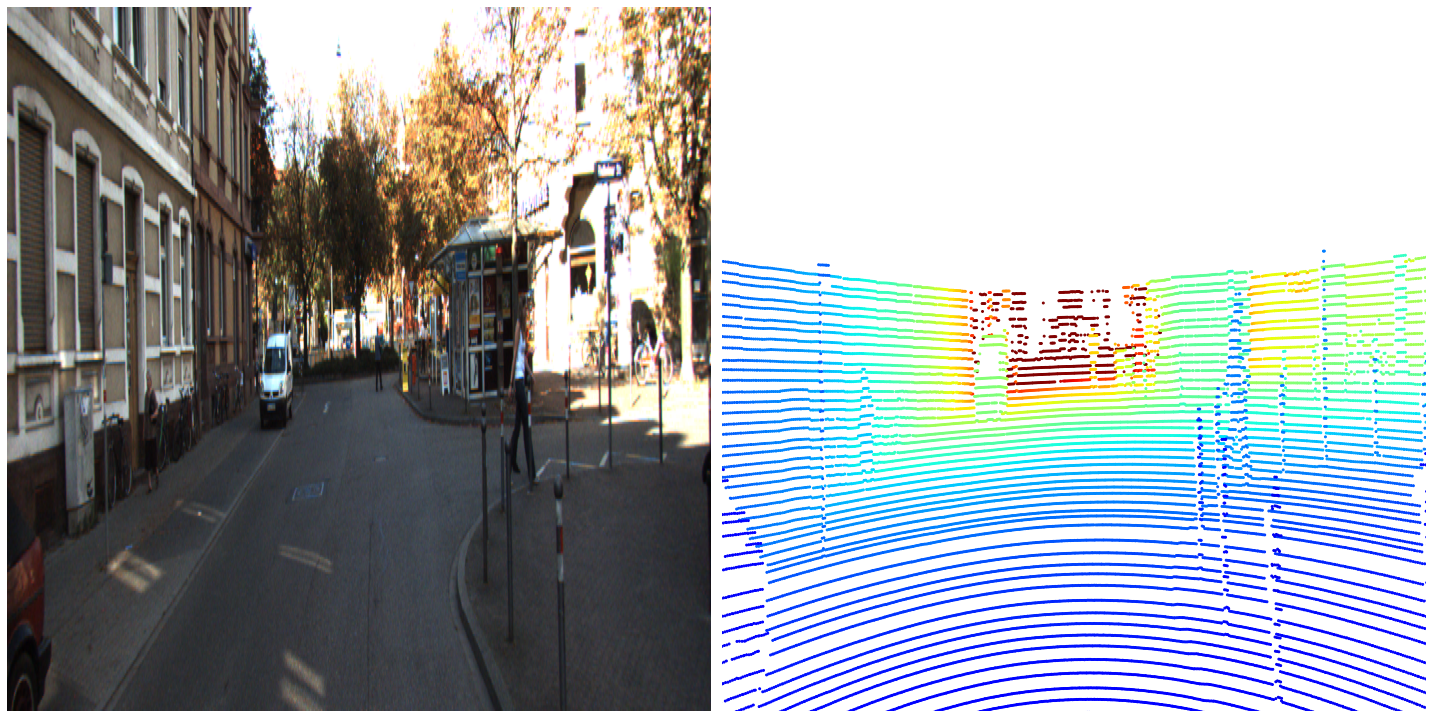

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 데이터 파일 경로
file_num = '000011'
calib_file = f'./calib/{file_num}.txt'
image_file = f'./training/image_2/{file_num}.png'
lidar_file = f'./vel/{file_num}.bin'

# 교정 파일 읽기 및 파싱
def read_calib_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    P0 = np.array([float(i) for i in lines[0].split(' ')[1:]]).reshape(3, 4)
    P1 = np.array([float(i) for i in lines[1].split(' ')[1:]]).reshape(3, 4)
    P2 = np.array([float(i) for i in lines[2].split(' ')[1:]]).reshape(3, 4)
    P3 = np.array([float(i) for i in lines[3].split(' ')[1:]]).reshape(3, 4)
    R0_rect = np.array([float(i) for i in lines[4].split(' ')[1:]]).reshape(3, 3)
    Tr_velo_to_cam = np.array([float(i) for i in lines[5].split(' ')[1:]]).reshape(3, 4)
    Tr_imu_to_velo = np.array([float(i) for i in lines[6].split(' ')[1:]]).reshape(3, 4)

    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo = read_calib_file(calib_file)

R0 = np.eye(4)
R0[:3, :3] = R0_rect
P = P2
Tr = np.vstack([Tr_velo_to_cam, [0, 0, 0, 1]])

# 이미지 읽기
img = cv2.imread(image_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# LiDAR 데이터 읽기
with open(lidar_file, 'rb') as f:
    data = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

# LiDAR 데이터를 이미지에 매핑
XYZ1 = np.vstack((data[:, :3].T, np.ones((1, data.shape[0]))))
xy1 = P @ R0 @ Tr @ XYZ1
s = xy1[2, :]
x = xy1[0, :] / s
y = xy1[1, :] / s

k = s > 0


# 이미지의 가로세로 비율을 계산합니다.
aspect_ratio = float(img.shape[1]) / img.shape[0]

# Figure의 크기를 조정합니다.
# figsize의 첫 번째 값(너비)를 이미지의 가로세로 비율에 맞추어 조정합니다.
fig, axs = plt.subplots(1, 2, figsize=(20, 25 ))

# 이미지 subplot
axs[0].imshow(img_rgb)
axs[0].axis('off')  # 축 정보 끄기

# 포인트 클라우드 subplot
x_values = data[:, 0][k]  # X 값 추출

# 데이터의 실제 범위를 기반으로 색상 맵 스케일링
x_min, x_max = np.percentile(x_values, 1), np.percentile(x_values, 99)  # 1%에서 99% 범위로 잘라냄으로써 outlier의 영향을 줄입니다.


# 컬러맵의 스케일을 조정합니다.
scatter = axs[1].scatter(x[k], img.shape[0] - y[k], c=x_values, cmap='jet', marker='.', s=15, vmin=x_min, vmax=x_max)
axs[1].set_xlim([0, img.shape[1]])
axs[1].set_ylim([0, img.shape[0]])
axs[1].axis('off')


# 색상 막대를 추가하여 x 값에 따른 색상 변화를 표시합니다.
# colorbar = fig.colorbar(scatter, ax=axs[1], fraction=0.02, pad=0.04)
# colorbar.set_label('X values')

# 서브플롯의 가로세로 비율을 이미지와 동일하게 설정합니다.
for ax in axs:
    ax.set_aspect(aspect_ratio)

plt.tight_layout()  # subplot 간격 조정
plt.show()



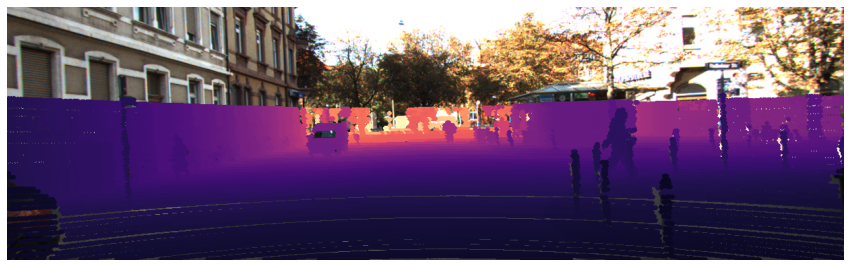

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming P, R0, Tr, data, and img are already defined and loaded as per previous steps.

# LiDAR data to image plane mapping
XYZ1 = np.vstack((data[:, :3].T, np.ones((1, data.shape[0]))))  # Adding a row of ones for homogeneous coordinates
xy1 = P @ R0 @ Tr @ XYZ1  # Projecting LiDAR points onto the image plane
s = xy1[2, :]
x = (xy1[0, :] / s).astype(np.int32)
y = (xy1[1, :] / s).astype(np.int32)

img_mapped = img.copy()  # Create a copy of the image to draw on
img_h, img_w = img.shape[:2]

# LiDAR 데이터를 이미지에 매핑하고, x 값에 따른 색상을 계산합니다.
x_normalized = (data[:, 0][k] - np.min(data[:, 0][k])) / (np.max(data[:, 0][k]) - np.min(data[:, 0][k]))
colors = plt.cm.magma(x_normalized)  # 'jet' 컬러맵을 사용하여 색상 계산

# 이미지 위에 색상화된 포인트를 그립니다.
for i, (ix, iy) in enumerate(zip(x[k], y[k])):
    if 0 <= ix < img_w and 0 <= iy < img_h:
        color = (colors[i] * 255).astype(np.uint8)[:3]  # RGBA에서 RGB로 변환
        color = (int(color[2]), int(color[1]), int(color[0]))  # RGB에서 BGR로 변환
        cv2.circle(img_mapped, (ix, iy), radius=2, color=color, thickness=2)

# 이미지를 RGB로 변환합니다.
img_mapped_rgb = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB)

# 이미지의 크기를 조절하고 시각화합니다.
plt.figure(figsize=(15, 10))
plt.imshow(img_mapped_rgb)
plt.axis('off')
plt.show()



